In [1127]:
#Librerias a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler

In [1128]:
#Importacion de datos
archivo_excel="fuente_banco.xlsx"
hojas=pd.read_excel(archivo_excel,sheet_name=None)
hojas_cliente=pd.read_excel(archivo_excel,sheet_name='CLIENTE')
hojas_cc=pd.read_excel(archivo_excel,sheet_name='CC')
hojas_tarjetas=pd.read_excel(archivo_excel,sheet_name='TARJETA')
hojas_prestamos=pd.read_excel(archivo_excel,sheet_name='PRESTAMO')

In [1129]:
# 1. Cálculo de Recencia para cada cliente, para este calculo tenemos en cuenta cuando saco su cc, cuando saco su tc y cuando saco su ultimo prestamo
recencia_cc = hojas_cc['FECHA ALTA'].max() -  hojas_cc.groupby('ID CLIENTE')['FECHA ALTA'].min()
recencia_tarjetas = hojas_tarjetas['FECHA PAGO'].max()  - hojas_tarjetas.groupby('ID CLIENTE')['FECHA PAGO'].max()
recencia_prestamos = hojas_prestamos['FECHA PAGO'].max()   - hojas_prestamos.groupby('ID CLIENTE')['FECHA PAGO'].max()
recencia = pd.concat([recencia_cc, recencia_tarjetas, recencia_prestamos], axis=1).min(axis=1)

In [1130]:
promedio_debito=hojas_cc['DEBITOS'].mean()
promedio_credito=hojas_cc['CREDITOS'].mean()
promedio_fin_mes=hojas_cc['SALDO FIN DE MES'].mean()
promedio_saldo_promedio=hojas_cc['SALDO PROMEDIO'].mean()
debitos_altos = hojas_cc[hojas_cc['DEBITOS'] >= promedio_debito]
credito_atos=hojas_cc[hojas_cc['CREDITOS']>=promedio_credito]
fin_alto=hojas_cc[hojas_cc['SALDO FIN DE MES']>=promedio_fin_mes]
saldo_promedio_alto=hojas_cc[hojas_cc['SALDO PROMEDIO']>=promedio_saldo_promedio]
veces_debito_alto_por_cliente = debitos_altos.groupby('ID CLIENTE').size()
veces_credito_alto_por_cliente=credito_atos.groupby('ID CLIENTE').size()
veces_fin_ato_por_cliente=fin_alto.groupby('ID CLIENTE').size()
veces_saldo_promedio_por_cliente=saldo_promedio_alto.groupby('ID CLIENTE').size()
frecuencia=veces_debito_alto_por_cliente.add(veces_credito_alto_por_cliente+veces_fin_ato_por_cliente+veces_saldo_promedio_por_cliente,fill_value=0)

In [1131]:
monetario_cc = hojas_cc.groupby('ID CLIENTE')['SALDO PROMEDIO'].sum()
monetario_cc_r=hojas_cc.groupby('ID CLIENTE').size()
saldo_promedio_cliente=monetario_cc /monetario_cc_r
monetario_tc_compra=hojas_tarjetas.groupby('ID CLIENTE')['COMPRA'].mean()
monetario_tc_pago=hojas_tarjetas.groupby('ID CLIENTE')['MONTO PAGO'].mean()
monetario_prestamo=hojas_prestamos.groupby('ID CLIENTE')['MONTO PRESTAMO'].mean()
indice_clientes = range(1, 101)
monetario_tc_compra = monetario_tc_compra.reindex(indice_clientes, fill_value=0)
monetario_tc_pago = monetario_tc_pago.reindex(indice_clientes, fill_value=0)
monetario_prestamo = monetario_prestamo.reindex(indice_clientes, fill_value=0)
monetario = saldo_promedio_cliente + monetario_tc_compra + monetario_tc_pago + monetario_prestamo

In [1132]:
RFM=pd.concat([recencia,frecuencia,monetario],axis=1)
RFM.columns=['Recencia','Frecuencia','Monetario']
RFM['Recencia'] = RFM['Recencia'].dt.days
RFM


,Recencia,Frecuencia,Monetario
ID CLIENTE,,,
1,0,47,1.046040e+07
2,4697,52,5.517583e+06
3,1249,54,9.597872e+06
4,4,43,1.208438e+07
5,697,44,2.482896e+07
...,...,...,...
96,3164,38,5.007938e+06
97,83,39,6.243921e+06
98,1177,51,5.821913e+06


In [1133]:
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

In [1134]:
from sklearn.cluster import KMeans
inertia=[]
for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

In [1135]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(scaled)
RFM["Grupos"]=(kmeans.labels_+1)

In [1136]:
def func(row):
    return

In [1137]:
def funcion_recencia(x,v1,v2,v3,v4):
    if x>=v1:
        return '1'
    elif x<v1 and x>=v2:
        return '2'
    elif x<v2 and x>=v3:
        return '3'
    elif x<v3 and x>=v4:
        return '4'
    else:
        return '5'    

In [1138]:
def funcion(x,v1,v2,v3,v4):
    if x>=v1:
        return '5'
    elif x<v1 and x>=v2:
        return '4'
    elif x<v2 and x>=v3:
        return '3'
    elif x<v3 and x>=v4:
        return '2'
    else:
        return '1'   

In [1139]:
v1=RFM['Recencia'].quantile(0.8)
v2=RFM['Recencia'].quantile(0.6)
v3=RFM['Recencia'].quantile(0.4)
v4=RFM['Recencia'].quantile(0.2)
RFM['Resultado_Recencia']=RFM.apply(lambda x:funcion_recencia(x['Recencia'],v1,v2,v3,v4),axis="columns")
RFM

,Recencia,Frecuencia,Monetario,Grupos,Resultado_Recencia
ID CLIENTE,,,,,
1,0,47,1.046040e+07,1,5
2,4697,52,5.517583e+06,2,1
3,1249,54,9.597872e+06,1,3
4,4,43,1.208438e+07,1,5
5,697,44,2.482896e+07,3,3
...,...,...,...,...,...
96,3164,38,5.007938e+06,2,2
97,83,39,6.243921e+06,1,4
98,1177,51,5.821913e+06,1,3


In [1140]:
v1=RFM['Frecuencia'].quantile(0.8)
v2=RFM['Frecuencia'].quantile(0.6)
v3=RFM['Frecuencia'].quantile(0.4)
v4=RFM['Frecuencia'].quantile(0.2)
RFM['Resultado_Frecuencia']=RFM.apply(lambda x:funcion(x['Frecuencia'],v1,v2,v3,v4),axis="columns")
RFM

,Recencia,Frecuencia,Monetario,Grupos,Resultado_Recencia,Resultado_Frecuencia
ID CLIENTE,,,,,,
1,0,47,1.046040e+07,1,5,3
2,4697,52,5.517583e+06,2,1,5
3,1249,54,9.597872e+06,1,3,5
4,4,43,1.208438e+07,1,5,2
5,697,44,2.482896e+07,3,3,2
...,...,...,...,...,...,...
96,3164,38,5.007938e+06,2,2,1
97,83,39,6.243921e+06,1,4,1
98,1177,51,5.821913e+06,1,3,5


In [1141]:
v1=RFM['Monetario'].quantile(0.8)
v2=RFM['Monetario'].quantile(0.6)
v3=RFM['Monetario'].quantile(0.4)
v4=RFM['Monetario'].quantile(0.2)
RFM['Resultado_Monetario']=RFM.apply(lambda x:funcion(x['Monetario'],v1,v2,v3,v4),axis="columns")
RFM

,Recencia,Frecuencia,Monetario,Grupos,Resultado_Recencia,Resultado_Frecuencia,Resultado_Monetario
ID CLIENTE,,,,,,,
1,0,47,1.046040e+07,1,5,3,4
2,4697,52,5.517583e+06,2,1,5,1
3,1249,54,9.597872e+06,1,3,5,4
4,4,43,1.208438e+07,1,5,2,4
5,697,44,2.482896e+07,3,3,2,5
...,...,...,...,...,...,...,...
96,3164,38,5.007938e+06,2,2,1,1
97,83,39,6.243921e+06,1,4,1,2
98,1177,51,5.821913e+06,1,3,5,2


In [1142]:
RFM['Resultado RFM']=RFM['Resultado_Recencia']+RFM['Resultado_Frecuencia']+RFM['Resultado_Monetario']
RFM

,Recencia,Frecuencia,Monetario,Grupos,Resultado_Recencia,Resultado_Frecuencia,Resultado_Monetario,Resultado RFM
ID CLIENTE,,,,,,,,
1,0,47,1.046040e+07,1,5,3,4,534
2,4697,52,5.517583e+06,2,1,5,1,151
3,1249,54,9.597872e+06,1,3,5,4,354
4,4,43,1.208438e+07,1,5,2,4,524
5,697,44,2.482896e+07,3,3,2,5,325
...,...,...,...,...,...,...,...,...
96,3164,38,5.007938e+06,2,2,1,1,211
97,83,39,6.243921e+06,1,4,1,2,412
98,1177,51,5.821913e+06,1,3,5,2,352


<table>
<thead>
<tr>
<th style="background-color: #0163ea; color: white;"><b>Segmento de clientes</b></th>
<th style="background-color: #0163ea; color: white;"><b>RFM</b></th>
<th style="background-color: #0163ea; color: white;"><b>Comportamiento</b></th>
<th style="background-color: #0163ea; color: white;"><b>Estrategias accionables</b></th>
</tr>
</thead>
<tbody>
<tr>
<td><b>Champions</b></td>
<td>555, 554, 544, 545, 454, 455, 445.</td>
<td>Compraron recientemente, suelen comprar con frecuencia y son los que más dinero gastan.</td>
<td>Recompénsalos. Pueden ser early adopters para nuevos productos. Son tus embajadores de marca.</td>
</tr>
<tr>
<td><b>Loyal customer</b></td>
<td>543, 444, 435, 355, 354, 345, 344, 335.</td>
<td>Gastan bastante dinero y con cierta frecuencia en tu eCommerce. Son sensibles a promociones.</td>
<td>Haz upselling con ellos. Ofréceles productos de más valor. Pídeles que dejen reviews. Fidelízalos.</td>
</tr>
<tr>
<td><b>Potential Loyalist</b></td>
<td>553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323.</td>
<td>Clientes recientes que gastaron una buena cantidad y compraron más de una vez.</td>
<td>Ofréceles un membership o programa de fidelización, recomiéndales otros productos.</td>
</tr>
<tr>
<td><b>New Customers</b></td>
<td>512, 511, 422, 421 412, 411, 311.</td>
<td>Han comprado recientemente, pero no compran a menudo.</td>
<td>Dales soporte para su on-boarding, haz que sientan que consiguen lo que buscan, comienza a construir una relación de confianza con ellos.</td>
</tr>
<tr>
<td><b>Promising</b></td>
<td>525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313.</td>
<td>Han comprado recientemente, pero no han gastado mucho.</td>
<td>Crea brand awareness, ofréceles descuentos, regalos o free trials.</td>
</tr>
<tr>
<td><b>Need Attention</b></td>
<td>535, 534, 443, 434, 343, 334, 325, 324.</td>
<td>Están por encima de la media en recencia, frecuencia y valor monetario, pero no han comprado recientemente.</td>
<td>Lanza ofertas limitadas en el tiempo y recomendaciones basadas en sus anteriores compras. Reactívalos.</td>
</tr>
<tr>
<td><b>Cannot Lose Them</b></td>
<td>155, 154, 144, 214,215,115, 114, 113 .</td>
<td>Hicieron las compras más grandes, y a menudo. Pero no han vuelto a tu eCommerce desde hace mucho tiempo.</td>
<td>Tráelos de vuelta con lanzamientos de nuevos productos, no dejes que se los lleve la competencia, habla con ellos.</td>
</tr>
<tr>
<td><b>About to sleep</b></td>
<td>331, 321, 312, 221, 213.</td>
<td>Por debajo de la media en recencia, frecuencia y valor monetario. Vas a perderlos si no los reactivas.</td>
<td>Comparte con ellos recursos de valor, recomiéndales productos populares, nuevos descuentos, etc. Reconecta con ellos.</td>
</tr>
<tr>
<td><b>At risk</b></td>
<td>255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124.</td>
<td>Gastaron mucho dinero y compraron con frecuencia, pero hace ya mucho tiempo de eso. ¡Necesitan que los traigas de vuelta!</td>
<td>Envíales emails personalizados para reconectar, ofréceles promociones&nbsp; y pon a su alcance recursos de valor.</td>
</tr>
<tr>
<td><b>Hibernating</b></td>
<td>332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211.</td>
<td>La última compra fue hace mucho tiempo, con poco gasto y bajo número de pedidos.</td>
<td>Ofréceles productos relevantes y descuentos especiales. Vuelve a crear valor de marca.</td>
</tr>
<tr>
<td><b>Lost</b></td>
<td>111, 112, 121, 131, 141, 151.</td>
<td>Tienen las puntuaciones más bajas en Recency, Frequency y Montetary.</td>
<td>Intenta recaptarlos con alguna campaña personalizada. Si no funciona, ignoralos.</td>
</tr>
</tbody>
</table>

In [1143]:
def asignar(r):
    champions=['555', '554', '544', '545', '454', '455', '445']
    loyal=['543', '444', '435', '355', '354', '345', '344', '335']
    potential_loyal=['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']
    new_customers=['512', '511', '422', '421', '412', '411', '311']
    promising=['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']
    need_attention=['535', '534', '443', '434', '343', '334', '325', '324']
    cannot_lose=['155', '154', '144', '214', '215', '115', '114', '113']
    about_to=['331','321','312','221','213']
    at_risk=['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']
    hibernating=['332', '322', '231', '241', '251', '233', '232', '223', '222', '132', '123', '122', '212', '211']
    lost=['111', '112', '121', '131', '141', '151']
    if r in champions:
        return 'VIP'
    elif r in loyal:
        return 'Cliente fiel'
    elif r in potential_loyal:
        return 'Cliente potencial'
    elif r in new_customers:
        return 'Nuevos clientes'
    elif r in promising:
        return 'Prometedor'
    elif r in need_attention:
        return 'Necesitan atencion'
    elif r in cannot_lose:
        return 'Imperdibles'
    elif r in about_to:
        return 'Apunto de perderlos'
    elif r in at_risk:
        return 'En riesgo'
    elif r in hibernating:
        return 'Hibernando'
    elif r in lost:
        return 'Perdidos'
    else:
        return 'Sin grupo'

In [1144]:
RFM['Segmento']=RFM['Resultado RFM'].map(asignar)

In [1145]:
RFM

,Recencia,Frecuencia,Monetario,Grupos,Resultado_Recencia,Resultado_Frecuencia,Resultado_Monetario,Resultado RFM,Segmento
ID CLIENTE,,,,,,,,,
1,0,47,1.046040e+07,1,5,3,4,534,Necesitan atencion
2,4697,52,5.517583e+06,2,1,5,1,151,Perdidos
3,1249,54,9.597872e+06,1,3,5,4,354,Cliente fiel
4,4,43,1.208438e+07,1,5,2,4,524,Prometedor
5,697,44,2.482896e+07,3,3,2,5,325,Necesitan atencion
...,...,...,...,...,...,...,...,...,...
96,3164,38,5.007938e+06,2,2,1,1,211,Hibernando
97,83,39,6.243921e+06,1,4,1,2,412,Nuevos clientes
98,1177,51,5.821913e+06,1,3,5,2,352,Cliente potencial


In [1146]:
#Datos utilizados para obtener si un cliente podria tener o no una tarjeta
dr=pd.read_excel(archivo_excel,sheet_name='CLIENTE')
dr.set_index('ID CLIENTE',inplace=True)
#El sexo en este caso no nos interesa para obtener si un cliente tiene un tc o no
dr.drop(columns=['SEXO'],inplace=True)
dr['TRABAJO']=dr['TRABAJO'].fillna('No trabaja')
dr['Trabajo'] = dr['TRABAJO'].apply(lambda x: 1 if x != 'No trabaja' else 0)
dr.drop(columns=['TRABAJO'],inplace=True)
#Edad del cliente
hoy = pd.Timestamp('now')
dr['Edad'] = ((hoy - dr['FECHA NACIMIENTO']).dt.days / 365.25).astype(int)
dr.drop(columns=['FECHA NACIMIENTO'], inplace=True)
#Antiguedad de la cuenta corriente
antiguedad=hojas_cc.groupby('ID CLIENTE')['FECHA ALTA'].max()
antiguedad
dr['Antiguedad']=antiguedad
dr['Antiguedad'] = ((hoy - dr['Antiguedad']).dt.days).astype(int)
#Obtener si tiene tarjeta o no
dr['Tiene tarjeta'] = dr.index.isin(hojas_tarjetas['ID CLIENTE']).astype(int)
#Saldo promedio que tuvo durante los periodo analizados en su cuenta corriente
saldo_promedio=hojas_cc.groupby('ID CLIENTE')['SALDO PROMEDIO'].mean()
#Debito promedio que tuvo en su cc durante los periodo analizados
debito_promedio=hojas_cc.groupby('ID CLIENTE')['DEBITOS'].mean()
#En caso de tener tarjeta, monto promedio de pago que hizo a su tarjeta(usaremos para la columna gastos)
monto_pago_promedio=hojas_tarjetas.groupby('ID CLIENTE')['MONTO PAGO'].mean()
#Monto promedio de plata que gasto de su tc, tambien lo usaremos para gastos
monto_compra_promedio=hojas_tarjetas.groupby('ID CLIENTE')['COMPRA'].mean()
#Credito promedio que tuvo en su cc durante los periodo analizados
credito_promedio=hojas_cc.groupby('ID CLIENTE')['CREDITOS'].mean()
#Saldo promedio que manejo la cuenta a fin de mes
fin_mes=hojas_cc.groupby('ID CLIENTE')['SALDO FIN DE MES'].mean()
dr['SALDO FIN DE MES']=fin_mes
dr['SALDO PROMEDIO']=saldo_promedio
debito_promedio=debito_promedio.add(monto_pago_promedio,fill_value=0)
debito_promedio=debito_promedio.add(monto_compra_promedio,fill_value=0)
dr['GASTOS PROMEDIO']=debito_promedio
dr['INGRESOS PROMEDIO']=credito_promedio
dr.drop(columns=['CIUDAD'],inplace=True)
dr

,Trabajo,Edad,Antiguedad,Tiene tarjeta,SALDO FIN DE MES,SALDO PROMEDIO,GASTOS PROMEDIO,INGRESOS PROMEDIO
ID CLIENTE,,,,,,,,
1,1,43,8427,1,6.194355e+06,5.767275e+06,6.307464e+06,6.518919e+06
2,1,37,6952,0,5.665190e+06,5.517583e+06,7.355821e+06,6.494752e+06
3,1,24,7059,0,6.466149e+06,5.169253e+06,6.061740e+06,6.742094e+06
4,1,43,3147,1,6.632926e+06,4.572633e+06,1.242321e+07,5.664085e+06
5,1,30,3720,0,5.515090e+06,5.696943e+06,6.144313e+06,6.269284e+06
...,...,...,...,...,...,...,...,...
96,0,50,5419,0,4.956445e+06,5.007938e+06,6.054811e+06,5.156506e+06
97,1,31,2338,0,4.817261e+06,6.243921e+06,5.124243e+06,5.826709e+06
98,1,53,3432,0,7.233642e+06,5.821913e+06,6.099377e+06,5.599469e+06


In [1147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Lista para almacenar las precisiones
precisiones = []
X = dr.drop(columns=['Tiene tarjeta'])
y = dr['Tiene tarjeta']
# Iterar 10 veces
for _ in range(10):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Inicializar y entrenar el modelo
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular la precisión y guardarla en la lista
    accuracy = accuracy_score(y_test, y_pred)
    precisiones.append(accuracy)

# Imprimir las precisiones obtenidas en cada iteración
for i, precision in enumerate(precisiones):
    print(f"Iteración {i+1}: Precisión del modelo: {precision}")


Iteración 1: Precisión del modelo: 0.9
Iteración 2: Precisión del modelo: 0.9
Iteración 3: Precisión del modelo: 0.9
Iteración 4: Precisión del modelo: 0.9
Iteración 5: Precisión del modelo: 0.9
Iteración 6: Precisión del modelo: 0.9
Iteración 7: Precisión del modelo: 0.9
Iteración 8: Precisión del modelo: 0.9
Iteración 9: Precisión del modelo: 0.9
Iteración 10: Precisión del modelo: 0.9


Características más importantes:
             Feature  Importance
5    GASTOS PROMEDIO    0.675812
3   SALDO FIN DE MES    0.087224
2         Antiguedad    0.072040
6  INGRESOS PROMEDIO    0.063951
4     SALDO PROMEDIO    0.052425
1               Edad    0.030593
0            Trabajo    0.017955


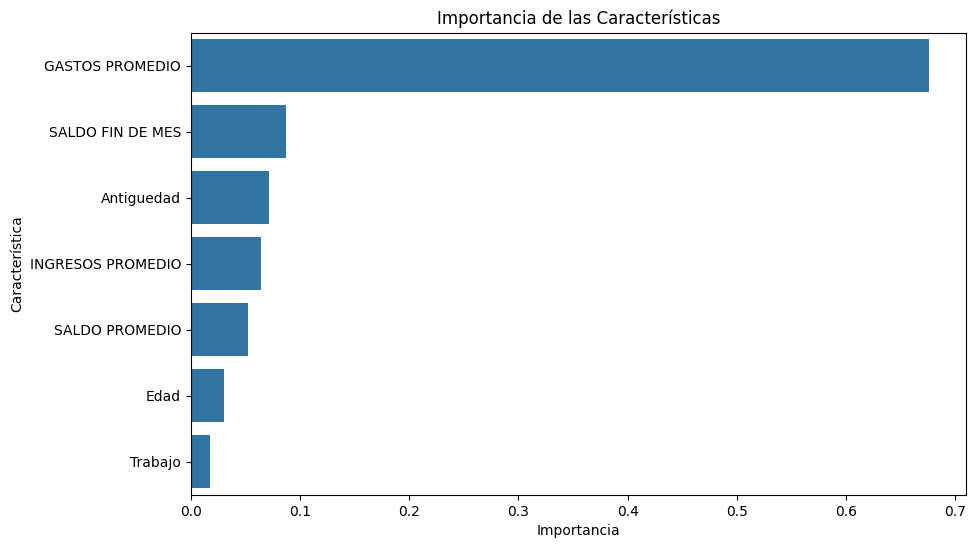

In [1148]:
importances = model.feature_importances_
feature_names = X.columns
# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Mostrar las características más importantes
print("Características más importantes:")
print(feature_importance_df)
# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importancia de las Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()

In [1149]:
import pandas as pd
import numpy as np
#Creamos valores aleatorios para ver a que clientes podriamos recomendar una tarjeta
copia_datos = dr.copy()
columnas_modificar = ['SALDO FIN DE MES', 'SALDO PROMEDIO', 'GASTOS PROMEDIO', 'INGRESOS PROMEDIO']
for columna in columnas_modificar:
    copia_datos[columna] = np.random.randint(1000000, 10000000, size=len(copia_datos))  # Se generan valores aleatorios entre 1,000,000 y 10,000,000
copia_datos['Trabajo'] = np.random.randint(0, 2, size=len(copia_datos))  # 0 o 1 para representar el trabajo
copia_datos['Edad'] = np.random.randint(18, 65, size=len(copia_datos))  # Edades entre 18 y 65 años
print(copia_datos)


            Trabajo  Edad  Antiguedad  Tiene tarjeta  SALDO FIN DE MES  \
ID CLIENTE                                                               
1                 0    26        8427              1           8413101   
2                 1    51        6952              0           5753756   
3                 0    44        7059              0           3127598   
4                 1    57        3147              1           9075237   
5                 0    18        3720              0           2009001   
...             ...   ...         ...            ...               ...   
96                0    53        5419              0           3231598   
97                1    22        2338              0           5113492   
98                0    33        3432              0           7946021   
99                1    46        2736              0           4834608   
100               0    25        8100              0           9017447   

            SALDO PROMEDIO  GASTOS PR

In [1150]:
# Suponiendo que tienes el modelo entrenado llamado modelo_recomendacion y el DataFrame dr que contiene los datos de todos los clientes
# Filtrar clientes que aún no tienen tarjeta
clientes_sin_tarjeta = copia_datos
# Eliminar la columna 'Tiene tarjeta', ya que será la que el modelo prediga
clientes_sin_tarjeta = clientes_sin_tarjeta.drop(columns=['Tiene tarjeta'])
# Realizar las predicciones con el modelo
predicciones = model.predict(clientes_sin_tarjeta)
# Crear un DataFrame con las predicciones y los datos originales de los clientes sin tarjeta
clientes_recomendados = clientes_sin_tarjeta.copy()
clientes_recomendados['Prediccion'] = predicciones
# Filtrar los clientes recomendados con una predicción positiva
clientes_recomendados['Prediccion'].value_counts()

Prediccion
0    81
1    19
Name: count, dtype: int64